This notebook uses a **XGBClassifier** model and tunes the parameters using **GridSearchCV**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn import preprocessing

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Check for missing values
train_data.isnull().sum()
# Age is missing - will impute after train/test split
# Cabin is frequently missing - will drop column
# Embarked is missing 2 - will ignore

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
# feature engineering 
# family size = parents + siblings
train_data['Family'] = train_data['SibSp']+train_data['Parch']
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [5]:
# Remove the missing / categorical / string columns
reduced_train_data = train_data.drop(['Cabin','Ticket','Name'], axis=1)
reduced_train_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family
0,1,0,3,male,22.0,1,0,7.2500,S,1
1,2,1,1,female,38.0,1,0,71.2833,C,1
2,3,1,3,female,26.0,0,0,7.9250,S,0
3,4,1,1,female,35.0,1,0,53.1000,S,1
4,5,0,3,male,35.0,0,0,8.0500,S,0


In [6]:
# Add one hot encoding for remaining categorical data
categorical = ['Sex','Embarked']
one_hot_encoded_train_data = pd.get_dummies(reduced_train_data, columns=categorical,drop_first=True)
one_hot_encoded_train_data.head()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Family,Sex_male,Embarked_Q,Embarked_S
0,1,0,3,22.0,1,0,7.2500,1,1,0,1
1,2,1,1,38.0,1,0,71.2833,1,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,0,1
3,4,1,1,35.0,1,0,53.1000,1,0,0,1
4,5,0,3,35.0,0,0,8.0500,0,1,0,1


<AxesSubplot:>

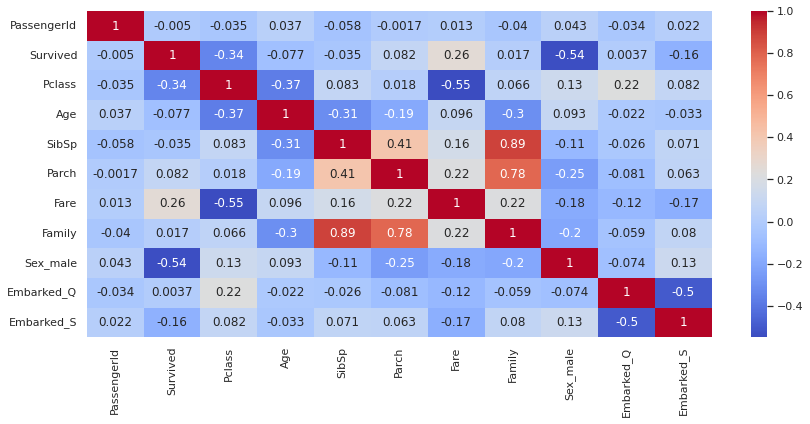

In [7]:
# Plot the correlation between the remaining data
sns.set(rc={'figure.figsize':(14,6)}) #set plot size
sns.heatmap(one_hot_encoded_train_data.corr(),annot=True,cmap= 'coolwarm')

In [8]:
# Set up validation data in the same way as the test / train data
validation_data = pd.read_csv("/kaggle/input/titanic/test.csv")
reduced_validation_data = validation_data.drop(['Cabin','Ticket','Name'], axis=1)
reduced_validation_data['Family'] = reduced_validation_data['SibSp']+reduced_validation_data['Parch']
one_hot_encoded_validation_data = pd.get_dummies(reduced_validation_data, columns=categorical,drop_first=True)
one_hot_encoded_validation_data.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Family,Sex_male,Embarked_Q,Embarked_S
0,892,3,34.5,0,0,7.8292,0,1,1,0
1,893,3,47.0,1,0,7.0000,1,0,0,1
2,894,2,62.0,0,0,9.6875,0,1,1,0
3,895,3,27.0,0,0,8.6625,0,1,0,1
4,896,3,22.0,1,1,12.2875,2,0,0,1


In [9]:
# Define X, y and validation set
y = train_data["Survived"] # values from original dataset
X = one_hot_encoded_train_data.drop('Survived',axis=1) # The validation set doesn't have the answers in it!
X_validation = one_hot_encoded_validation_data

In [10]:
# Split the data into train and test subsets
# this is random, so run again for a different split
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)

In [11]:
# Fill in age, embarked missing values for train data set only
# Note this happens only AFTER the train/test split to avoid data contamination
X_train['Age'] = X_train['Age'].fillna(X_train['Age'].mean())

# Check for missing values again - there should be none!
X_train.isnull().sum()

# Note - XGBoost can handle missing values if you want it to!  This step is not needed.

PassengerId    0
Pclass         0
Age            0
SibSp          0
Parch          0
Fare           0
Family         0
Sex_male       0
Embarked_Q     0
Embarked_S     0
dtype: int64

In [12]:
# Define our model and fit it
# I've read elsewhere that a solo XGBoost can expect around 77-80% accuracy for this project

evalset = [(X_train, y_train), (X_test,y_test)]

# try various params 
# note that large ranges will take a long time to compute
# because AxBxCxD for each param list size
parameters = {
    # primary params to tune - model size and complexity
    'n_estimators':[50,60,70], #np.arange(11,11,1), # default 100
    'max_depth':[5,6,7], # default 6
    'learning_rate':[0.05], # default 0.3 
    # secondary - model behavior
    'min_child_weight': [1.3], # default 1
    'subsample':[0.7], # default 1
    'colsample_bytree': [0.7], # default 1
    # tertiary - regularization params to address potential overfitting
    'reg_alpha':[0.3], # default 0 
    'reg_lambda':[1.3], # default 1
    'gamma':[20], # default 0
}

model = XGBClassifier(early_stopping_rounds=5,
                      objective='binary:logistic',
                      random_state=1,
                      eval_metric=["error", "logloss"],
                     )
grid = GridSearchCV(model,
                    parameters,
                    cv = 2,
                    n_jobs = 5,
                    verbose=True)
grid.fit(X_train, y_train, eval_set = evalset, verbose=False)
print(grid.best_score_)
print(grid.best_params_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
0.773876404494382
{'colsample_bytree': 0.7, 'gamma': 20, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1.3, 'n_estimators': 50, 'reg_alpha': 0.3, 'reg_lambda': 1.3, 'subsample': 0.7}


In [13]:
# set the best params!
model.set_params(**grid.best_params_)

# fit model to train set and evaluate on test set
model.fit(X_train, y_train,eval_set=evalset,verbose=False)

# Generate predictions
predictions = model.predict(X_test)

# Calculate metrics
print('Accuracy Score',sklearn.metrics.accuracy_score(y_test,predictions))
print('F1 Score',sklearn.metrics.f1_score(y_test,predictions))
print('Precision',sklearn.metrics.precision_score(y_test,predictions))
print('Recall',sklearn.metrics.recall_score(y_test,predictions))

# This competition is based on accuracy on the validation set!
# If this accuracy is lower than the best accuracy above, you probably over or underfit!

Accuracy Score 0.8379888268156425
F1 Score 0.7716535433070867
Precision 0.8166666666666667
Recall 0.7313432835820896


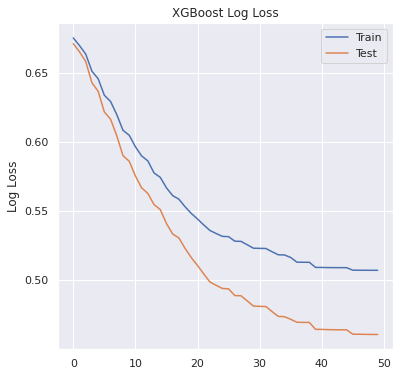

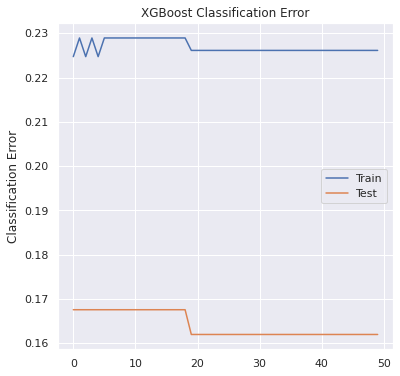

In [14]:
    # Generate some plots to show the learning process
    # Evaluate model results
    results = model.evals_result()
    epochs = len(results["validation_0"]["logloss"])
    x_axis = range(0, epochs)
    
    # plot log loss
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
    ax.plot(x_axis, results["validation_1"]["logloss"], label="Test")
    ax.legend()
    plt.ylabel("Log Loss")
    plt.title("XGBoost Log Loss")
    plt.show()

    # plot classification error
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(x_axis, results["validation_0"]["error"], label="Train")
    ax.plot(x_axis, results["validation_1"]["error"], label="Test")
    ax.legend()
    plt.ylabel("Classification Error")
    plt.title("XGBoost Classification Error")
    plt.show()

If the Test error increases while the Train error decreases or stays the same - Overfitting

In [15]:
# optionally, split the data again and retest the cell above
#Split the data into train and test subsets
# this is random, so run again for a different split
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)

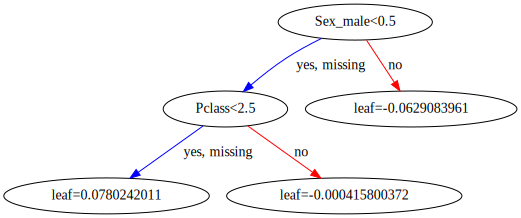

In [16]:
# View the model
xgb.to_graphviz(model)

# Does the tree make sense to you?  Is it too small or too complex?

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

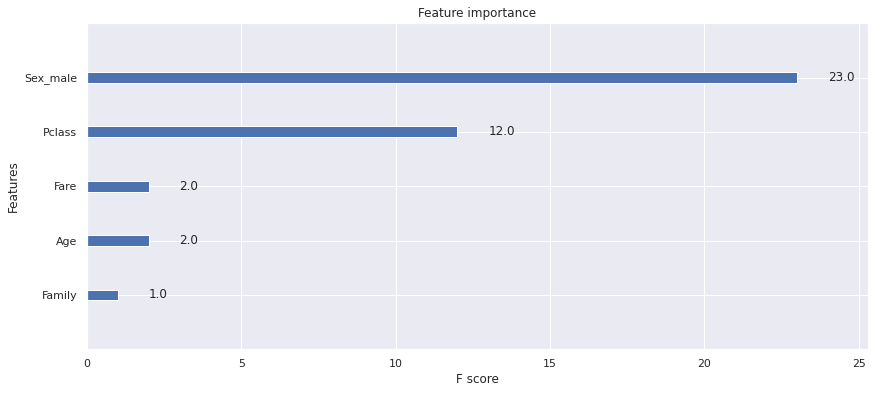

In [17]:
# Feature importance of model
xgb.plot_importance(model)

<AxesSubplot:>

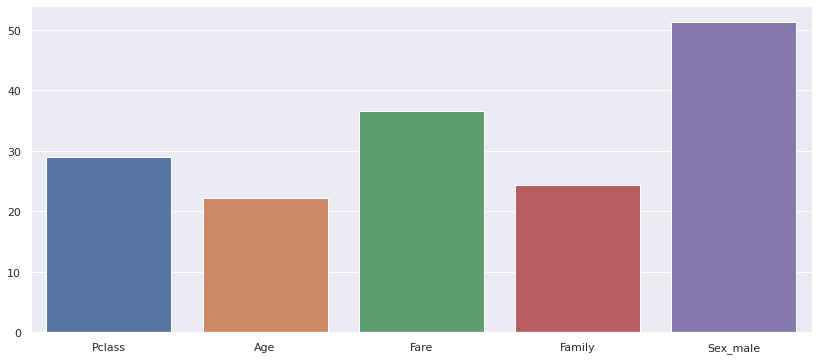

In [18]:
# Feature gain, according to XGBoost
dict = model.get_booster().get_score(importance_type="gain")
keys = list(dict.keys())
vals = [dict[k] for k in keys]
sns.barplot(x=keys, y=vals)

In [19]:
# make predictions on validation data
validation_predictions = model.predict(X_validation)
output = pd.DataFrame({'PassengerId': validation_data.PassengerId, 'Survived': validation_predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved! Woooo!")

Your submission was successfully saved! Woooo!


In [20]:
# verify output formatting (sanity check letfover from first few runs)
output.head(10)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
